In [1]:
import os
import time
import pathlib

import numpy as np
import tensorflow as tf
import PIL.Image as Image
import tensorflow_hub as hub
import matplotlib.pylab as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dir= pathlib.Path("/home/m3/Projects/Image-Clasification/Fruit_Vegetable_Classification/Dataset/V2/Train")
test_dir= pathlib.Path("/home/m3/Projects/Image-Clasification/Fruit_Vegetable_Classification/Dataset/V2/Test")

train_ds = image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
test_ds = image_dataset_from_directory(test_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

class_names = train_ds.class_names
n_class=len(class_names)

Found 576 files belonging to 8 classes.
Found 128 files belonging to 8 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
dp=tf.keras.layers.Dropout(0.2)

In [6]:
base_model= hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",input_shape=(224,224,3),trainable=True)

In [7]:
model = tf.keras.Sequential([
  data_augmentation,
  rescale,
  base_model,
  dp,
  tf.keras.layers.Dense(n_class)
])

model.build([None, 224, 224, 3])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 4,236,680
Trainable params: 4,212,280
Non-trainable params: 24,400
_________________________________________________________________


In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [10]:
loss0, accuracy0 = model.evaluate(test_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


8/8 [==============================] - 4s 34ms/step - loss: 2.5774 - accuracy: 0.0781
initial loss: 2.58
initial accuracy: 0.08


In [11]:
history = model.fit(train_ds,
                    epochs=14,
                    validation_data=test_ds)


Epoch 1/14
36/36 [==============================] - 16s 183ms/step - loss: 1.2069 - accuracy: 0.7031 - val_loss: 0.5958 - val_accuracy: 0.9297
Epoch 2/14
36/36 [==============================] - 7s 182ms/step - loss: 0.4462 - accuracy: 0.9583 - val_loss: 0.3399 - val_accuracy: 0.9922
Epoch 3/14
36/36 [==============================] - 7s 184ms/step - loss: 0.3445 - accuracy: 0.9722 - val_loss: 0.2924 - val_accuracy: 0.9844
Epoch 4/14
36/36 [==============================] - 7s 183ms/step - loss: 0.2986 - accuracy: 0.9913 - val_loss: 0.2716 - val_accuracy: 1.0000
Epoch 5/14
36/36 [==============================] - 7s 183ms/step - loss: 0.2970 - accuracy: 0.9861 - val_loss: 0.2768 - val_accuracy: 0.9922
Epoch 6/14
36/36 [==============================] - 7s 180ms/step - loss: 0.2790 - accuracy: 0.9931 - val_loss: 0.2626 - val_accuracy: 1.0000
Epoch 7/14
36/36 [==============================] - 7s 181ms/step - loss: 0.2951 - accuracy: 0.9826 - val_loss: 0.2653 - val_accuracy: 1.0000
Epoch

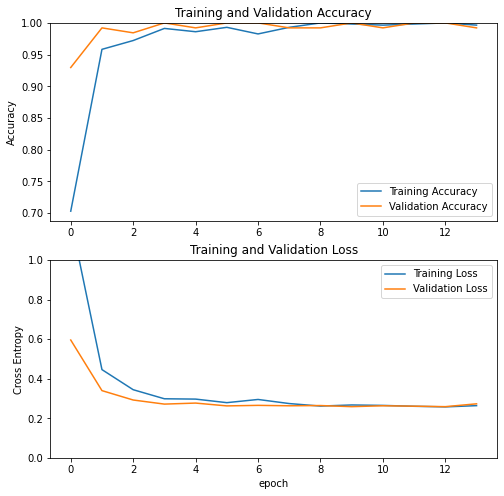

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [13]:
export_path = "saved_models/MNV3_14E_TL-True"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/MNV3_14E_TL-True/assets


INFO:tensorflow:Assets written to: saved_models/MNV3_14E_TL-True/assets


'saved_models/MNV3_14E_TL-True'

In [20]:
ep="Dataset/V2/Eval/"
files=os.listdir(ep)
files.sort()

In [22]:
for i in range(len(files)):
    img = keras.preprocessing.image.load_img(ep+files[i], target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    #print(score)
    print("{}--{}--{}\n".format(files[i],class_names[np.argmax(score)], 100 * np.max(score)))
    

Fava_Beans_4.jpg--Fava_Beans--99.99719858169556

Gar_42.jpg--Garlic--99.87999200820923

Garlic_96.jpg--Garlic--99.99700784683228

Ging_39.jpg--Ginger--99.97870326042175

Ginger_84.jpg--Ginger--99.97214674949646

Green_Chilly_76.jpg--Green_Chilly--99.813312292099

Ok_22.jpg--Okra--99.9961256980896

Ok_39.jpg--Okra--99.99938011169434

fb_15.jpg--Fava_Beans--99.9488115310669

gc_41.jpg--Green_Chilly--98.72024655342102

